In [26]:
from lamp import Pinv_ilamp
from NNinv import NNinv_torch

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE, Isomap, MDS
from sklearn.preprocessing import MinMaxScaler

from sklearn.datasets import make_swiss_roll
# mnist 
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

### Generate some data

In [33]:
# X, y = make_swiss_roll(n_samples=2000, noise=0.2, random_state=0, hole=False)

# ## scale the data to [0,1] is required for the NNinv
# scaler = MinMaxScaler()
# X = scaler.fit_transform(X)

# ## plot the original data
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# ax.scatter(X[:,0], X[:,1], X[:,2], c=y, cmap=plt.cm.jet)

## MNIST
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.astype('float32')/255.0
y = y.astype('int64')

X, _, y, _ = train_test_split(X, y, train_size=3000, random_state=42)

## select only 0 and 7 
mask = (y == 0) | (y == 7)
X = np.array(X[mask])
y = np.array(y[mask])
print(X.shape, y.shape)


C:\Users\yuwan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(608, 784) (608,)


### Build  P and $P^{-1}$

C:\Users\yuwan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


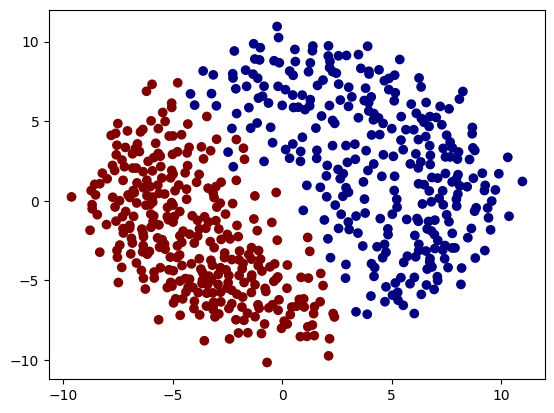

In [34]:
## P
X2d = MDS(n_components=2).fit_transform(X)

plt.scatter(X2d[:,0], X2d[:,1], c=y, cmap=plt.cm.jet)

In [35]:
## Pinv with ilamp
ilamp = Pinv_ilamp(k=6)
ilamp.fit(X2d, X)

## Pinv with NNinv
nninv = NNinv_torch(dims=[2048, 2048, 2048, 2048],) ## this structure is according the original paper, but it seems too large for most of the datasets we teset (like any 3D dataset, or the MNIST). But it works
nninv.fit(X2d, X, epochs=100)

device:  cuda:0
Epoch 1/100, Loss: 0.13774552
Epoch 2/100, Loss: 0.09022442
Epoch 3/100, Loss: 0.07789381
Epoch 4/100, Loss: 0.07155517
Epoch 5/100, Loss: 0.06881616
Epoch 6/100, Loss: 0.06542280
Epoch 7/100, Loss: 0.06054886
Epoch 8/100, Loss: 0.05394474
Epoch 9/100, Loss: 0.05254056
Epoch 10/100, Loss: 0.05139377
Epoch 11/100, Loss: 0.05059229
Epoch 12/100, Loss: 0.04970815
Epoch 13/100, Loss: 0.04851868
Epoch 14/100, Loss: 0.04603423
Epoch 15/100, Loss: 0.04379982
Epoch 16/100, Loss: 0.04254404
Epoch 17/100, Loss: 0.04125529
Epoch 18/100, Loss: 0.04044013
Epoch 19/100, Loss: 0.03974011
Epoch 20/100, Loss: 0.03922584
Epoch 21/100, Loss: 0.03874859
Epoch 22/100, Loss: 0.03839574
Epoch 23/100, Loss: 0.03809154
Epoch 24/100, Loss: 0.03784441
Epoch 25/100, Loss: 0.03762460
Epoch 26/100, Loss: 0.03743789
Epoch 27/100, Loss: 0.03726611
Epoch 28/100, Loss: 0.03710715
Epoch 29/100, Loss: 0.03693677
Epoch 30/100, Loss: 0.03684305
Epoch 31/100, Loss: 0.03681892
Epoch 32/100, Loss: 0.03680527
E

In [36]:
## sample some points in the 2D space

xmin, xmax = X2d[:,0].min(), X2d[:,0].max()
ymin, ymax = X2d[:,1].min(), X2d[:,1].max()

x_ = np.linspace(xmin, xmax, 10)
y_ = np.linspace(ymin, ymax, 10)

xx, yy = np.meshgrid(x_, y_)
samples = np.c_[xx.ravel(), yy.ravel()]

## Pinv with ilamp
samples_ilamp = ilamp.transform(samples)

## Pinv with NNinv
samples_nninv = nninv.transform(samples)


100%|██████████| 100/100 [00:00<00:00, 99864.38it/s]


Text(0.5, 0.98, 'NNinv')

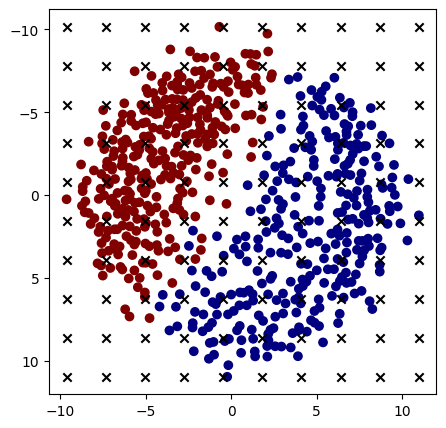

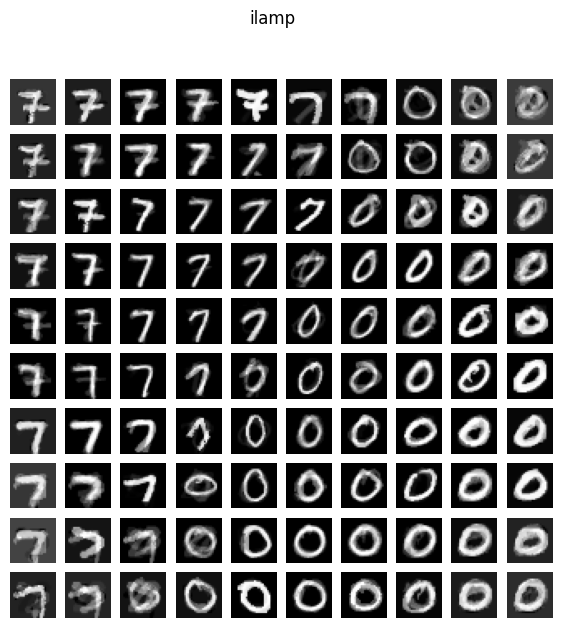

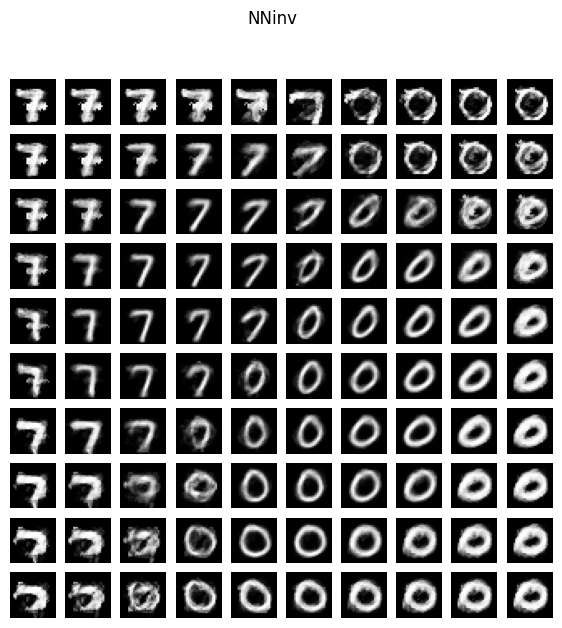

In [44]:
## plot the results
fig, ax = plt.subplots(1, 1, figsize=(5,5))

ax.scatter(X2d[:,0], X2d[:,1], c=y, cmap=plt.cm.jet)
ax.scatter(samples[:,0], samples[:,1], c='black', marker='x')
ax.invert_yaxis()

## results of ilamp
fig1, axes = plt.subplots(10, 10, figsize=(7,7))
for i in range(100):
    ax = axes[i//10, i%10]
    ax.imshow(samples_ilamp[i].reshape(28,28), cmap='gray')
    ax.axis('off')
fig1.suptitle('ilamp')

## results of NNinv
fig2, axes = plt.subplots(10, 10, figsize=(7,7))
for i in range(100):
    ax = axes[i//10, i%10]
    ax.imshow(samples_nninv[i].reshape(28,28), cmap='gray')
    ax.axis('off')
fig2.suptitle('NNinv', )